In [1]:
import sys
import numpy as np
import pandas as pd
import pickle
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import itertools
import random

from sklearn.utils import shuffle

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, Activation, Input, concatenate
from tensorflow.keras.models import Model

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform

from tensorflow.keras.layers import Layer
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
   

from keras.layers import Input, Convolution2D, ZeroPadding2D, MaxPooling2D, Flatten, Dense, Dropout
from PIL import Image

import tensorflow
tensorflow.__version__

Using TensorFlow backend.


'2.1.0'

In [2]:
os.listdir()

['.git',
 '.ipynb_checkpoints',
 'CNN_Car.ipynb',
 'data',
 'images',
 'index.html',
 'PreView_Data.ipynb',
 'README.md',
 'styles.css']

In [3]:
path='data/'
# fetching all directories list

dirList=next(os.walk(path))[1]
dirList.sort()
dirList

['Annotations-20210510T185520Z-001', 'Car Images-20210501T094840Z-001']

In [4]:
path1='data/Car Images-20210501T094840Z-001/Car Images/Train Images'
path2='data/Car Images-20210501T094840Z-001/Car Images/Test Images'
path3='data\Annotations-20210510T185520Z-001\Annotations'
# fetching all directories list

dirList=next(os.walk(path1))[1]
dirList.sort()
dirList



['AM General Hummer SUV 2000',
 'Acura Integra Type R 2001',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi A5 Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi S4 Sedan 2007',
 'Audi S4 Sedan 2012',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S6 Sedan 2011',
 'Audi TT Hatchback 2011',
 'Audi TT RS Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi V8 Sedan 1994',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3 SUV 2012',
 'BMW X5 SUV 2007',
 'BMW X6

In [5]:
def get_immediate_subdirectories(a_dir):
    return [name for name in os.listdir(a_dir)
            if os.path.isdir(os.path.join(a_dir, name))]

In [6]:
cat_Folder_list=get_immediate_subdirectories(path1)

In [7]:
trnImg=0
df=pd.DataFrame(columns=['Car Details','No of Images'])
df2=pd.DataFrame(columns=['file_name','fol_details'])
for img in cat_Folder_list:
    c1=len(os.listdir(os.path.join(path1, img)))
    df=df.append({'Car Details': img ,'No of Images' : c1},ignore_index=True)
    for filename in os.listdir(os.path.join(path1, img)):
        df2=df2.append({'file_name':filename,'fol_details':img},ignore_index=True)
    #print('{}   -->   {} training images'.format(img, len(os.listdir(os.path.join(path1, img)))))
    trnImg+=c1
    
print('Total Traing Images:',trnImg)
    
df

Total Traing Images: 8144


,Car Details,No of Images
0,Acura Integra Type R 2001,45
1,Acura RL Sedan 2012,32
2,Acura TL Sedan 2012,43
3,Acura TL Type-S 2008,42
4,Acura TSX Sedan 2012,41
...,...,...
191,Volkswagen Golf Hatchback 1991,46
192,Volkswagen Golf Hatchback 2012,43
193,Volvo 240 Sedan 1993,46
194,Volvo C30 Hatchback 2012,42


In [8]:
df2

,file_name,fol_details
0,00198.jpg,Acura Integra Type R 2001
1,00255.jpg,Acura Integra Type R 2001
2,00308.jpg,Acura Integra Type R 2001
3,00374.jpg,Acura Integra Type R 2001
4,00878.jpg,Acura Integra Type R 2001
...,...,...
8139,06632.jpg,Volvo XC90 SUV 2007
8140,07369.jpg,Volvo XC90 SUV 2007
8141,07413.jpg,Volvo XC90 SUV 2007
8142,07609.jpg,Volvo XC90 SUV 2007


In [9]:
df_annotations=pd.read_csv(os.path.join(path3, 'Train Annotations.csv'))

In [10]:
df_annotations

,Image Name,Bounding Box coordinates,Unnamed: 2,Unnamed: 3,Unnamed: 4,Image class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106
...,...,...,...,...,...,...
8139,08140.jpg,3,44,423,336,78
8140,08141.jpg,138,150,706,523,196
8141,08142.jpg,26,246,660,449,163
8142,08143.jpg,78,526,1489,908,112


In [11]:
df_annotations.columns=['file_name','x1','y1','x2','y2','class_Id']

#df_annotations=df_annotations.rename(columns={'Bounding Box coordinates':'x1','Unnamed: 2':'y1','Unnamed: 3':'x2','Unnamed: 4':'y2'})

In [12]:
df_annotations.sample(5)

,file_name,x1,y1,x2,y2,class_Id
2188,02189.jpg,36,331,857,692,163
1570,01571.jpg,48,120,589,371,172
3528,03529.jpg,74,81,476,431,85
3419,03420.jpg,12,5,282,161,90
1403,01404.jpg,436,574,1465,940,163


In [13]:
df_merged=pd.merge(df2,df_annotations,on='file_name')
df_merged.sample(5)

,file_name,fol_details,x1,y1,x2,y2,class_Id
2690,06772.jpg,Chevrolet Monte Carlo Coupe 2007,28,43,236,152,72
3405,05536.jpg,Dodge Caliber Wagon 2007,11,18,190,126,84
3935,02135.jpg,Dodge Ram Pickup 3500 Quad Cab 2009,67,103,533,366,87
3318,05488.jpg,Chrysler Town and Country Minivan 2012,60,63,587,417,78
6375,05975.jpg,Land Rover LR2 SUV 2012,128,152,433,322,155


In [14]:
df_merged.head()

,file_name,fol_details,x1,y1,x2,y2,class_Id
0,00198.jpg,Acura Integra Type R 2001,91,121,574,357,6
1,00255.jpg,Acura Integra Type R 2001,29,78,734,396,6
2,00308.jpg,Acura Integra Type R 2001,16,136,775,418,6
3,00374.jpg,Acura Integra Type R 2001,9,184,740,499,6
4,00878.jpg,Acura Integra Type R 2001,101,162,882,650,6


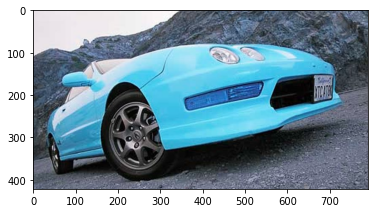

In [15]:
plt.imshow(cv2.imread('{}/{}/{}'.format(path1, df_merged.fol_details[1],df_merged.file_name[1])),cmap=None)

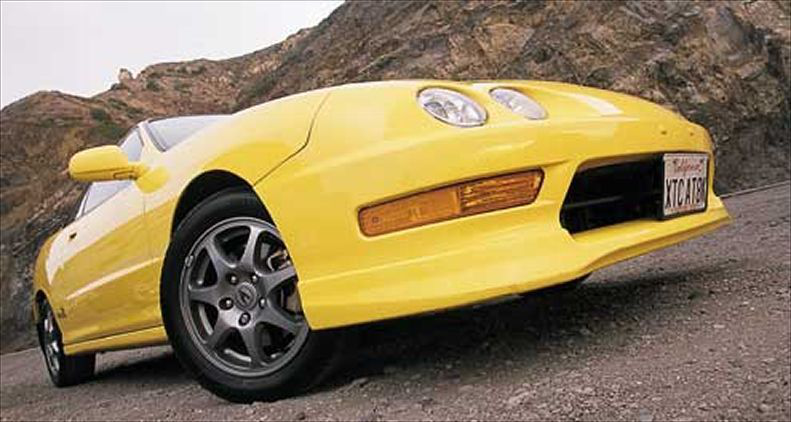

In [16]:
Image.open('{}/{}/{}'.format(path1, df_merged.fol_details[1],df_merged.file_name[1]))

In [17]:
Image.open('{}/{}/{}'.format(path1, df_merged.fol_details[1],df_merged.file_name[1])).size

(791, 422)

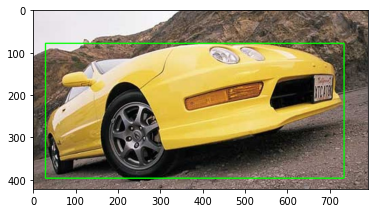

In [18]:
#file='F:\\GreatLearning\\AI\\ComputerVision\\Project2\\Part1\\training_images\\img001.PNG'
im = cv2.imread(str('{}/{}/{}'.format(path1, df_merged.fol_details[1],df_merged.file_name[1])))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)#change color space
cv2.rectangle(im,( int(df_merged.x1[1]),int(df_merged.y1[1])), (int(df_merged.x2[1]),int(df_merged.y2[1])), (0,255,0), 2)

plt.imshow(im)

In [19]:
im.shape

(422, 791, 3)

In [20]:
def viewImage(path,df,i):
    im = cv2.imread(str('{}/{}/{}'.format(path, df.fol_details[i],df.file_name[i])))
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)#change color space
    cv2.rectangle(im,( int(df.x1[i]),int(df.y1[i])), (int(df.x2[i]),int(df.y2[i])), (0,255,0), 2)

    plt.imshow(im)

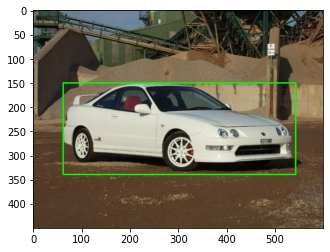

In [21]:
viewImage(path1,df_merged,9)

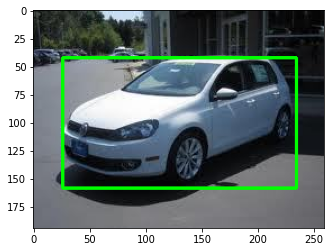

In [22]:
viewImage(path1,df_merged,8000)

#### For test

In [23]:
dirList2=next(os.walk(path2))[1]
dirList2.sort()
dirList2

['AM General Hummer SUV 2000',
 'Acura Integra Type R 2001',
 'Acura RL Sedan 2012',
 'Acura TL Sedan 2012',
 'Acura TL Type-S 2008',
 'Acura TSX Sedan 2012',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012',
 'Aston Martin Virage Convertible 2012',
 'Aston Martin Virage Coupe 2012',
 'Audi 100 Sedan 1994',
 'Audi 100 Wagon 1994',
 'Audi A5 Coupe 2012',
 'Audi R8 Coupe 2012',
 'Audi RS 4 Convertible 2008',
 'Audi S4 Sedan 2007',
 'Audi S4 Sedan 2012',
 'Audi S5 Convertible 2012',
 'Audi S5 Coupe 2012',
 'Audi S6 Sedan 2011',
 'Audi TT Hatchback 2011',
 'Audi TT RS Coupe 2012',
 'Audi TTS Coupe 2012',
 'Audi V8 Sedan 1994',
 'BMW 1 Series Convertible 2012',
 'BMW 1 Series Coupe 2012',
 'BMW 3 Series Sedan 2012',
 'BMW 3 Series Wagon 2012',
 'BMW 6 Series Convertible 2007',
 'BMW ActiveHybrid 5 Sedan 2012',
 'BMW M3 Coupe 2012',
 'BMW M5 Sedan 2010',
 'BMW M6 Convertible 2010',
 'BMW X3 SUV 2012',
 'BMW X5 SUV 2007',
 'BMW X6

In [24]:
cat_Folder_list2=get_immediate_subdirectories(path2)

In [25]:
def getFileDetails_df(path,folderList):
    totalImg=0
    df_overview=pd.DataFrame(columns=['Car Details','No of Images'])
    df_FileDetails=pd.DataFrame(columns=['file_name','fol_details'])
    for img in folderList:
        c1=len(os.listdir(os.path.join(path, img)))
        df_overview=df_overview.append({'Car Details': img ,'No of Images' : c1},ignore_index=True)
        for filename in os.listdir(os.path.join(path, img)):
            df_FileDetails=df_FileDetails.append({'file_name':filename,'fol_details':img},ignore_index=True)
        #print('{}   -->   {} training images'.format(img, len(os.listdir(os.path.join(path1, img)))))
        totalImg+=c1

    print('Total Images:',totalImg)  
    return df_overview,df_FileDetails
    


In [26]:
df_overviewTest, df_test=getFileDetails_df(path2,cat_Folder_list2)

Total Images: 8041


In [27]:
df_test.head(5)

,file_name,fol_details
0,00128.jpg,Acura Integra Type R 2001
1,00130.jpg,Acura Integra Type R 2001
2,00386.jpg,Acura Integra Type R 2001
3,00565.jpg,Acura Integra Type R 2001
4,00711.jpg,Acura Integra Type R 2001


In [28]:
df_annotations_test=pd.read_csv(os.path.join(path3, 'Test Annotation.csv'))
df_annotations_test.head(5)

,Image Name,Bounding Box coordinates,Unnamed: 2,Unnamed: 3,Unnamed: 4,Image class
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185


In [29]:
df_annotations_test.columns=['file_name','x1','y1','x2','y2','class_Id']


df_test_merged=pd.merge(df_test,df_annotations_test,on='file_name')
df_test_merged.head(5)

,file_name,fol_details,x1,y1,x2,y2,class_Id
0,00128.jpg,Acura Integra Type R 2001,122,149,743,455,6
1,00130.jpg,Acura Integra Type R 2001,27,74,774,449,6
2,00386.jpg,Acura Integra Type R 2001,86,184,723,425,6
3,00565.jpg,Acura Integra Type R 2001,15,1,545,347,6
4,00711.jpg,Acura Integra Type R 2001,126,65,735,347,6


In [30]:
df_test_merged.sample(5)

,file_name,fol_details,x1,y1,x2,y2,class_Id
6267,01116.jpg,Land Rover LR2 SUV 2012,66,66,314,235,155
2188,01098.jpg,Chevrolet Camaro Convertible 2012,19,186,734,413,59
4580,04231.jpg,Ford Focus Sedan 2007,28,1,582,401,115
877,04614.jpg,Audi TT Hatchback 2011,1,31,269,176,19
2225,07276.jpg,Chevrolet Camaro Convertible 2012,42,76,379,262,59


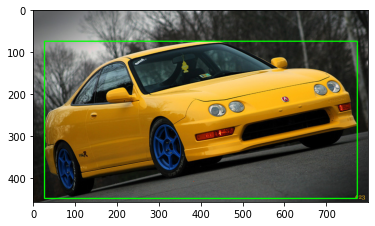

In [31]:
viewImage(path2,df_test_merged,1)

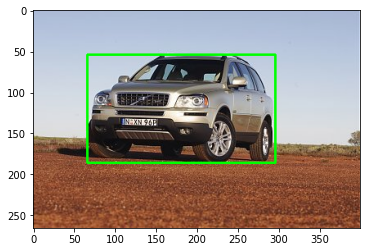

In [32]:
viewImage(path2,df_test_merged,8000)

#### Horizontal Flip

In [33]:
 def loadImage(path,df,i):
    im = cv2.imread(str('{}/{}/{}'.format(path, df.fol_details[i],df.file_name[i])))[:,:,::-1]
    #im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)#change color space
    #cv2.rectangle(im,( int(df.x1[i]),int(df.y1[i])), (int(df.x2[i]),int(df.y2[i])), (0,255,0), 2)

    return im

In [34]:
img=loadImage(path1, df_merged,1)
print(np.array(img.shape[:2])[::-1])
print(np.array(img.shape[:2])[::-1]/2)

[791 422]
[395.5 211. ]


In [35]:
print(np.array(img.shape[:2][::-1]))

[791 422]


In [36]:
box_w=abs(df_merged.x1[1] - df_merged.x2[1])
box_w

705

In [37]:
df_merged.x1[1]-box_w

-676

In [38]:
img1 = cv2.imread(str('{}/{}/{}'.format(path1, df_merged.fol_details[1],df_merged.file_name[1])))[:,:,::-1]
img1 =  img1[:,::-1,:]

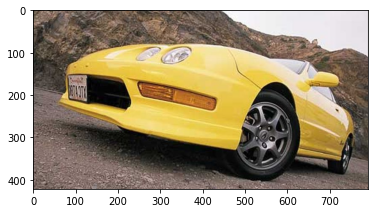

In [39]:
plt.imshow(img1)

In [40]:
img=loadImage(path1, df_merged,1)
bboxes=np.array([df_merged.x1[1],df_merged.y1[1],df_merged.x2[1],df_merged.y2[1]])
print(bboxes)
img_center = np.array(img.shape[:2])[::-1]/2
img_center = np.hstack((img_center, img_center))
print(img_center)
img =  img[:,::-1,:]
bboxes[[0,2]] = bboxes[[0,2]] + 2*(img_center[[0,2]] - bboxes[[0,2]])
print(bboxes)
print(box_w)
box_w = abs(bboxes[0] - bboxes[2])
bboxes[0] -= box_w
bboxes[2] += box_w
print(bboxes)

[ 29  78 734 396]
[395.5 211.  395.5 211. ]
[762  78  57 396]
705
[ 57  78 762 396]


In [41]:
bboxes

array([ 57,  78, 762, 396], dtype=int64)

In [42]:
bboxes[[0,2]]

array([ 57, 762], dtype=int64)

In [43]:
img_center

array([395.5, 211. , 395.5, 211. ])

In [44]:
box_w

705

In [45]:
df_merged.head(2)

,file_name,fol_details,x1,y1,x2,y2,class_Id
0,00198.jpg,Acura Integra Type R 2001,91,121,574,357,6
1,00255.jpg,Acura Integra Type R 2001,29,78,734,396,6


In [46]:
bboxes

array([ 57,  78, 762, 396], dtype=int64)

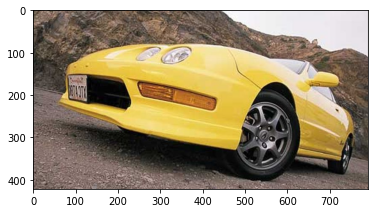

In [47]:
plt.imshow(img)

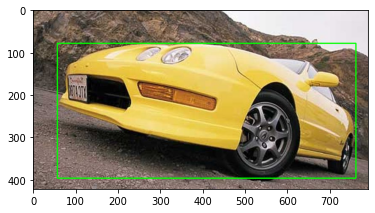

In [48]:
im=cv2.rectangle(img.copy(), (bboxes[0],bboxes[1]), (bboxes[2],bboxes[3]), (0,255,0), 2)
plt.imshow(im)

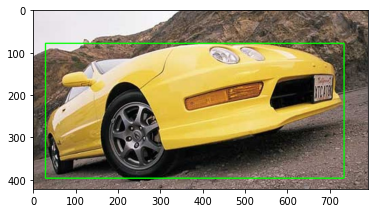

In [49]:
viewImage(path1,df_merged,1)

In [50]:
def horzFlip(path, df,i):
    img=loadImage(path, df,i)
    bboxes=np.array([df.x1[i],df.y1[i],df.x2[i],df.y2[i]])
    #print(bboxes)
    img_center = np.array(img.shape[:2])[::-1]/2
    img_center = np.hstack((img_center, img_center))

    img =  img[:,::-1,:]
    bboxes[[0,2]] = bboxes[[0,2]] + 2*(img_center[[0,2]] - bboxes[[0,2]])
    #print(bboxes)
    box_w = abs(bboxes[0] - bboxes[2])
    bboxes[0] = bboxes[0] - box_w
    bboxes[2] = bboxes[2] + box_w
    #print(bboxes)
    
    return img, bboxes

def viewUpdatedImg(image,bbox):
    im=cv2.rectangle(image.copy(), (bbox[0],bbox[1]), (bbox[2],bbox[3]), (0,255,0), 2)
    plt.imshow(im)

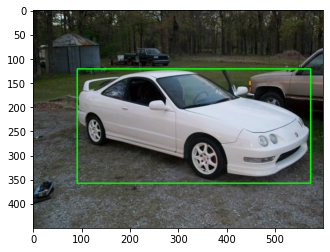

In [51]:
viewImage(path1,df_merged,0)

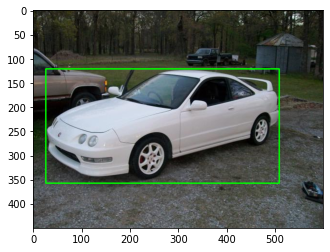

In [52]:
img0,bboxes0=horzFlip(path1,df_merged,0)
viewUpdatedImg(img0,bboxes0)

#### Scaling

In [53]:
scale=0.2

'''
One can chose to maintain the aspect ratio by constraining the scaling factor to be the same for both height and width. 
However, we can allow the scale factors to differ which not only produces a scaling augmentation 
but also changes the aspect ratio of the images. 
We introduce a boolean variable diff that can turn on/off this functionality.'''

diff=True


In [54]:
if (type(scale) == tuple):
    assert len(scale) == 2, "Invalid range"
    assert scale[0] > -1, "Scale factor can't be less than -1"
    assert scale[1] > -1, "Scale factor can't be less than -1"
else:
    assert scale > 0, "Please input a positive float"
    scale = (max(-1, -scale), scale)

In [55]:
scale

(-0.2, 0.2)

In [56]:
img=loadImage(path1, df_merged,1)
bboxes=np.array([df_merged.x1[1],df_merged.y1[1],df_merged.x2[1],df_merged.y2[1]])
bboxes

array([ 29,  78, 734, 396], dtype=int64)

In [57]:
import random
img_shape = img.shape
        
if diff:
    scale_x = random.uniform(*scale)
    scale_y = random.uniform(*scale)
else:
    scale_x = random.uniform(*scale)
    scale_y = scale_x

resize_scale_x = 1 + scale_x
resize_scale_y = 1 + scale_y

img=  cv2.resize(img, None, fx = resize_scale_x, fy = resize_scale_y)

bboxes[:4] = bboxes[:4]  * [resize_scale_x, resize_scale_y, resize_scale_x, resize_scale_y]

In [58]:
canvas = np.zeros(img_shape, dtype = np.uint8)

In [59]:
y_lim = int(min(resize_scale_y,1)*img_shape[0])
x_lim = int(min(resize_scale_x,1)*img_shape[1])

canvas[:y_lim,:x_lim,:] =  img[:y_lim,:x_lim,:]

img = canvas

In [60]:
def clip_box(bbox, clip_box):

    ar_ = (bbox_area(bbox))
    bbox[0] = np.maximum(bbox[0], clip_box[0])
    bbox[1] = np.maximum(bbox[1], clip_box[1])
    bbox[2] = np.minimum(bbox[2], clip_box[2])
    bbox[3] = np.minimum(bbox[3], clip_box[3])
    #print(x_min)
    #bbox = np.hstack((x_min, y_min, x_max, y_max, bbox[4:]))
    #print(bbox)
    #delta_area = ((ar_ - bbox_area(bbox))/ar_)
    
    #mask = (delta_area < (1 - alpha)).astype(int)
    
    #bbox = bbox[mask == 1,:]


    return bbox

def bbox_area(bbox):
    return (bbox[2] - bbox[0])*(bbox[3] - bbox[1])

In [61]:
print(bboxes)

[ 26  62 667 317]


In [62]:
bboxes = clip_box(bboxes, [0,0,1 + img_shape[1], img_shape[0]])
bboxes

array([ 26,  62, 667, 317], dtype=int64)

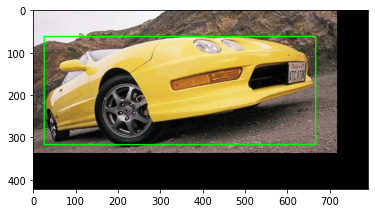

In [63]:
viewUpdatedImg(img,bboxes)

In [64]:
def scaleImage(path, df,i,scale,diff):
    
    if (type(scale) == tuple):
        assert len(scale) == 2, "Invalid range"
        assert scale[0] > -1, "Scale factor can't be less than -1"
        assert scale[1] > -1, "Scale factor can't be less than -1"
    else:
        assert scale > 0, "Please input a positive float"
        scale = (max(-1, -scale), scale)
        
    
    img=loadImage(path, df,i)
    bboxes=np.array([df.x1[i],df.y1[i],df.x2[i],df.y2[i]])
    
    img_shape = img.shape
        
    if diff:
        scale_x = random.uniform(*scale)
        scale_y = random.uniform(*scale)
    else:
        scale_x = random.uniform(*scale)
        scale_y = scale_x

    resize_scale_x = 1 + scale_x
    resize_scale_y = 1 + scale_y

    img=  cv2.resize(img, None, fx = resize_scale_x, fy = resize_scale_y)

    bboxes[:4] = bboxes[:4]  * [resize_scale_x, resize_scale_y, resize_scale_x, resize_scale_y]
    
    canvas = np.zeros(img_shape, dtype = np.uint8)
    
    y_lim = int(min(resize_scale_y,1)*img_shape[0])
    x_lim = int(min(resize_scale_x,1)*img_shape[1])

    canvas[:y_lim,:x_lim,:] =  img[:y_lim,:x_lim,:]

    img = canvas
    
    bboxes = clip_box(bboxes, [0,0,1 + img_shape[1], img_shape[0]])
    
    return img, bboxes

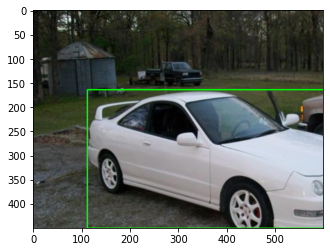

In [65]:
img,bboxes=scaleImage(path1,df_merged,0,0.4,True)
viewUpdatedImg(img,bboxes)

In [66]:
bboxes

array([112, 164, 601, 450], dtype=int64)

#### Translate

In [67]:
def translateImage(path, df,i,translate,diff):
    
    if type(translate) == tuple:
        assert len(translate) == 2, "Invalid range"  
        assert translate[0] > 0 and translate[0] < 1
        assert translate[1] > 0 and translate[1] < 1
    else:
        assert translate > 0.0 and translate < 1.0
        translate = (-translate, translate)
        
    
    img=loadImage(path, df,i)
    bboxes=np.array([df.x1[i],df.y1[i],df.x2[i],df.y2[i]])
    
    img_shape = img.shape
        
    translate_factor_x = random.uniform(*translate)
    translate_factor_y = random.uniform(*translate)
    
    if not diff:
        translate_factor_y = translate_factor_x
        
    canvas = np.zeros(img_shape).astype(np.uint8)
    
    corner_x = int(translate_factor_x*img.shape[1])
    corner_y = int(translate_factor_y*img.shape[0])
    
    orig_box_cords =  [max(0,corner_y), 
                       max(corner_x,0), 
                       min(img_shape[0], corner_y + img.shape[0]), 
                       min(img_shape[1],corner_x + img.shape[1])
                      ]
    
    mask = img[max(-corner_y, 0):min(img.shape[0], -corner_y + img_shape[0]), max(-corner_x, 0):min(img.shape[1], -corner_x + img_shape[1]),:]
    canvas[orig_box_cords[0]:orig_box_cords[2], orig_box_cords[1]:orig_box_cords[3],:] = mask
    img = canvas
    
    bboxes[:4] = bboxes[:4] + [corner_x, corner_y, corner_x, corner_y]
    
    bboxes = clip_box(bboxes, [0,0,img_shape[1], img_shape[0]])
    
    return img, bboxes

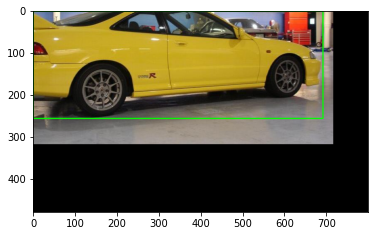

In [68]:
img,bboxes=translateImage(path1,df_merged,2,0.4,True)
viewUpdatedImg(img,bboxes)

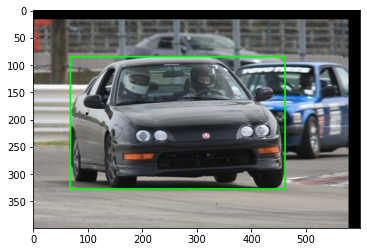

In [69]:
img,bboxes=translateImage(path1,df_merged,5,0.2,True)
viewUpdatedImg(img,bboxes)

In [70]:
bboxes

array([ 68,  85, 462, 327], dtype=int64)

#### Rotate

In [71]:
#rotate_im
def rotate_im(image, angle):

    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    #center = tuple(np.array(image.shape)[:2]/2)

    # print(angle[0],cX,cY)
    
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    image = cv2.warpAffine(image, M, (nW, nH))

#    image = cv2.resize(image, (w,h))
    return image

In [72]:
def get_corners(bboxes):
    
    width = (bboxes[2] - bboxes[0]).reshape(-1,1)
    height = (bboxes[3] - bboxes[1]).reshape(-1,1)
    
    x1 = bboxes[0].reshape(-1,1)
    y1 = bboxes[1].reshape(-1,1)
    
    x2 = x1 + width
    y2 = y1 
    
    x3 = x1
    y3 = y1 + height
    
    x4 = bboxes[2].reshape(-1,1)
    y4 = bboxes[3].reshape(-1,1)
    
    corners = np.hstack((x1,y1,x2,y2,x3,y3,x4,y4))
    
    return corners

In [73]:
def rotate_box(corners,angle,  cx, cy, h, w):


    corners = corners.reshape(-1,2)
    corners = np.hstack((corners, np.ones((corners.shape[0],1), dtype = type(corners[0][0]))))
    
    M = cv2.getRotationMatrix2D((cx, cy), angle, 1.0)
    
    
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cx
    M[1, 2] += (nH / 2) - cy
    # Prepare the vector to be transformed
    calculated = np.dot(M,corners.T).T
    
    calculated = calculated.reshape(-1,8)
    
    return calculated

In [74]:
def get_enclosing_box(corners):

    x_ = corners[[0,2,4,6]]
    y_ = corners[[1,3,5,7]]
    
    
    xmin = np.min(x_).reshape(-1,1)
    ymin = np.min(y_).reshape(-1,1)
    xmax = np.max(x_).reshape(-1,1)
    ymax = np.max(y_).reshape(-1,1)
    
    #print(xmin,xmin[0])
    
    final = np.hstack((xmin[0], ymin[0], xmax[0], ymax[0],corners[8:]))
    
    return final

In [75]:
def rotateImageBBox(path, df,i,angle):
    
    
    if type(angle) == tuple:
        assert len(angle) == 2, "Invalid Range"
    else:
        angle = (-angle,angle)
    
    angle = random.uniform(*angle)
    
    img=loadImage(path, df,i)
    bboxes=np.array([df.x1[i],df.y1[i],df.x2[i],df.y2[i]])
    
    #angle = random.uniform(*self.angle)

    w,h = img.shape[1], img.shape[0]
    cx, cy = w//2, h//2
    
    img = rotate_im(img, angle)

    corners = get_corners(bboxes)

    corners = np.hstack((corners[0], bboxes[4:]))


    corners[:8] = rotate_box(corners[:8], angle, cx, cy, h, w)

    new_bbox = get_enclosing_box(corners)


    scale_factor_x = img.shape[1] / w

    scale_factor_y = img.shape[0] / h

    img = cv2.resize(img, (w,h))

    new_bbox[:4] = new_bbox[:4]  / [scale_factor_x, scale_factor_y, scale_factor_x, scale_factor_y] 

    bboxes  = new_bbox

    bboxes = clip_box(bboxes, [0,0,w, h])

    return img, bboxes

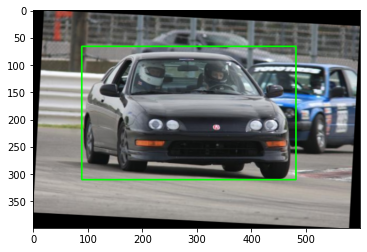

In [76]:
img,bboxes=rotateImageBBox(path1,df_merged,5,30.0)
viewUpdatedImg(img,bboxes)

#### Shearing

In [77]:
def shearImage(path, df,i,shear_factor):
 
    if type(shear_factor) == tuple:
        assert len(shear_factor) == 2, "Invalid range for scaling factor"   
    else:
        shear_factor = (-shear_factor, shear_factor)
        
    shear_factor = random.uniform(*shear_factor)          
     
    img=loadImage(path, df,i)
    bboxes=np.array([df.x1[i],df.y1[i],df.x2[i],df.y2[i]])
    
    w,h = img.shape[1], img.shape[0]

    if shear_factor < 0:
        img, bboxes = horzFlip(path,df,i)

    M = np.array([[1, abs(shear_factor), 0],[0,1,0]])

    nW =  img.shape[1] + abs(shear_factor*img.shape[0])

    bboxes[[0,2]] = bboxes[[0,2]] + ((bboxes[[1,3]]) * abs(shear_factor) ).astype(int) 


    img = cv2.warpAffine(img, M, (int(nW), img.shape[0]))

    if shear_factor < 0:
        img, bboxes = horzFlip(path,df,i)

    img = cv2.resize(img, (w,h))

    scale_factor_x = nW / w

    bboxes[:4] = bboxes[:4] / [scale_factor_x, 1, scale_factor_x, 1] 


    return img, bboxes

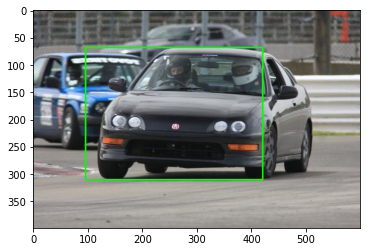

In [78]:
img,bboxes=shearImage(path1,df_merged,5,0.7)
viewUpdatedImg(img,bboxes)

### Resizing

In [79]:
def letterbox_image(img, inp_dim):
    '''resize image with unchanged aspect ratio using padding'''
    img_w, img_h = img.shape[1], img.shape[0]
    w, h = inp_dim
    new_w = int(img_w * min(w/img_w, h/img_h))
    new_h = int(img_h * min(w/img_w, h/img_h))
    print(new_h,new_w)
    resized_image = cv2.resize(img, (new_w,new_h), interpolation = cv2.INTER_CUBIC)
    
    canvas = np.full((inp_dim[1], inp_dim[0], 3), 256)
 
    canvas[(h-new_h)//2:(h-new_h)//2 + new_h,(w-new_w)//2:(w-new_w)//2 + new_w,  :] = resized_image
    
    return canvas

In [80]:
def resize(path, df,i,inp_dim):

    img=loadImage(path, df,i)
    bboxes=np.array([df.x1[i],df.y1[i],df.x2[i],df.y2[i]])
    
    w,h = img.shape[1], img.shape[0]
    img = letterbox_image(img, inp_dim)


    scale = min(inp_dim[1]/h, inp_dim[0]/w)
    bboxes[:4] = bboxes[:4]  * (scale)

    new_w = scale*w
    new_h = scale*h
    inp_dim = inp_dim   

    del_h = (inp_dim[1] - new_h)/2
    del_w = (inp_dim[0] - new_w)/2

    add_matrix = np.array([[del_w, del_h, del_w, del_h]]).astype(int)

    bboxes[:4] = bboxes[:4] + add_matrix

    img = img.astype(np.uint8)

    return img, bboxes

85 128


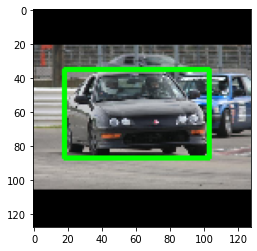

In [81]:
img,bboxes=resize(path1,df_merged,5,(128,128))
viewUpdatedImg(img,bboxes)

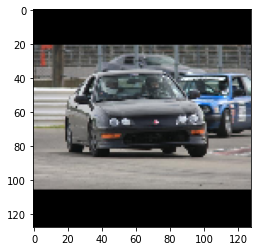

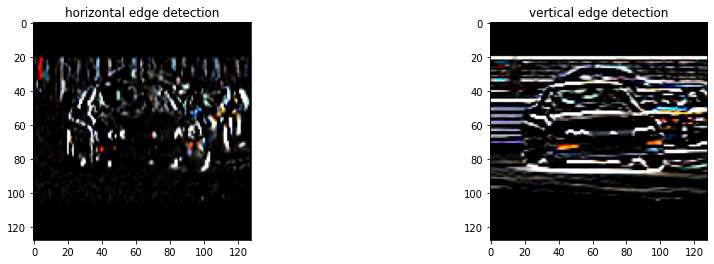

In [82]:
image=img
plt.imshow(image, cmap='gray')
# 3x3 sobel filter for horizontal edge detection
sobel_y = np.array([[ -1, -2, -1], 
                   [ 0, 0, 0], 
                   [ 1, 2, 1]])
# vertical edge detection
sobel_x = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]])
# filter the image using filter2D(grayscale image, bit-depth, kernel)  
filtered_image1 = cv2.filter2D(image, -1, sobel_x)
filtered_image2 = cv2.filter2D(image, -1, sobel_y)
f, ax = plt.subplots(1, 2, figsize=(15, 4))
ax[0].set_title('horizontal edge detection')
ax[0].imshow(filtered_image1, cmap='gray')
ax[1].set_title('vertical edge detection')
ax[1].imshow(filtered_image2, cmap='gray')

In [83]:
#capture basic details of images
def imgBasics(pic):
    #pic = imageio.imread(img1)
    plt.figure(figsize = (5,5))
    plt.imshow(pic)

    #Basic properties of image
    print('Type of the image : ' , type(pic)) 
    print('Shape of the image : {}'.format(pic.shape)) 
    print('Image Hight {}'.format(pic.shape[0])) 
    print('Image Width {}'.format(pic.shape[1])) 
    print('Dimension of Image {}'.format(pic.ndim))
    print('Image size {}'.format(pic.size)) 
    print('Maximum RGB value in this image {}'.format(pic.max())) 
    print('Minimum RGB value in this image {}'.format(pic.min()))
    print('Value of only R channel {}'.format(pic[ 100, 50, 0])) 
    print('Value of only G channel {}'.format(pic[ 100, 50, 1])) 
    print('Value of only B channel {}'.format(pic[ 100, 50, 2]))

Type of the image :  <class 'numpy.ndarray'>
Shape of the image : (128, 128, 3)
Image Hight 128
Image Width 128
Dimension of Image 3
Image size 49152
Maximum RGB value in this image 255
Minimum RGB value in this image 0
Value of only R channel 174
Value of only G channel 171
Value of only B channel 166


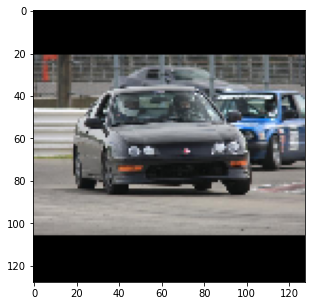

In [84]:
imgBasics(img)